<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:13:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


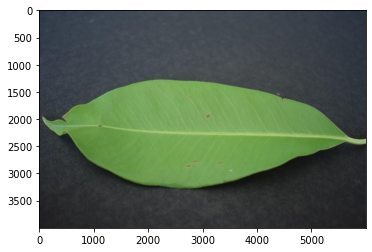

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

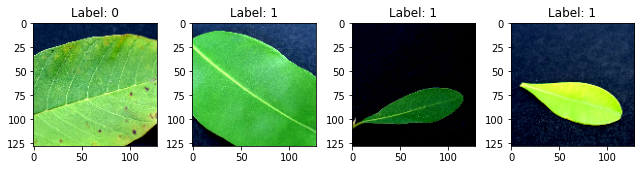

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2609776814258358 samples/sec                   batch loss = 0.536774218082428 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2693679586810425 samples/sec                   batch loss = 0.8745567798614502 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2704546278915305 samples/sec                   batch loss = 1.2614967823028564 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2696580677834448 samples/sec                   batch loss = 0.4547244608402252 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2288294607063088 samples/sec                   batch loss = 0.4949652850627899 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2713441861096013 samples/sec                   batch loss = 0.5224801898002625 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2692059587533422 samples/sec                   batch loss = 0.46766018867492676 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.2702950435583613 samples/sec                   batch loss = 0.4664304852485657 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.2676270194730148 samples/sec                   batch loss = 0.32809627056121826 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2753671222844445 samples/sec                   batch loss = 1.4819672107696533 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.2708883726384295 samples/sec                   batch loss = 0.8894587159156799 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2702266625449377 samples/sec                   batch loss = 0.4821435809135437 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2748128058339279 samples/sec                   batch loss = 0.40716585516929626 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2727715216012576 samples/sec                   batch loss = 0.7613263130187988 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2724018180618515 samples/sec                   batch loss = 0.4641019105911255 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2680440756983167 samples/sec                   batch loss = 0.403807133436203 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2730770993550393 samples/sec                   batch loss = 0.4164484441280365 | accuracy = 0.6411764705882353


Epoch[1] Batch[90] Speed: 1.2748457412440684 samples/sec                   batch loss = 0.24971896409988403 | accuracy = 0.6444444444444445


Epoch[1] Batch[95] Speed: 1.2662980659861336 samples/sec                   batch loss = 0.6193300485610962 | accuracy = 0.6342105263157894


Epoch[1] Batch[100] Speed: 1.2706067464812818 samples/sec                   batch loss = 1.534367322921753 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.2672874837540473 samples/sec                   batch loss = 0.673022449016571 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2731780572404439 samples/sec                   batch loss = 1.0875327587127686 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2720368621331322 samples/sec                   batch loss = 0.6766338348388672 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.277166637307767 samples/sec                   batch loss = 0.5105211138725281 | accuracy = 0.6270833333333333


Epoch[1] Batch[125] Speed: 1.2707596715139524 samples/sec                   batch loss = 0.5046874284744263 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.268317950977349 samples/sec                   batch loss = 0.4120021462440491 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2659566625384198 samples/sec                   batch loss = 0.31253066658973694 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2691640970906735 samples/sec                   batch loss = 0.35697993636131287 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.2651569537566465 samples/sec                   batch loss = 0.6047822833061218 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.2630441297887047 samples/sec                   batch loss = 0.3323158919811249 | accuracy = 0.6366666666666667


Epoch[1] Batch[155] Speed: 1.2670930938537825 samples/sec                   batch loss = 0.6710224151611328 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.2655983535740718 samples/sec                   batch loss = 1.3108489513397217 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2700532905289175 samples/sec                   batch loss = 1.4773473739624023 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.2724509386110432 samples/sec                   batch loss = 0.6117759943008423 | accuracy = 0.6426470588235295


Epoch[1] Batch[175] Speed: 1.2727819497763992 samples/sec                   batch loss = 0.4944438934326172 | accuracy = 0.6428571428571429


Epoch[1] Batch[180] Speed: 1.268556070295717 samples/sec                   batch loss = 0.6986770033836365 | accuracy = 0.6444444444444445


Epoch[1] Batch[185] Speed: 1.2700540596845806 samples/sec                   batch loss = 0.8103501200675964 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.272506336472071 samples/sec                   batch loss = 0.4999725818634033 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.2693087043556543 samples/sec                   batch loss = 0.7396407127380371 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2739246762342795 samples/sec                   batch loss = 1.1373133659362793 | accuracy = 0.64125


Epoch[1] Batch[205] Speed: 1.2720325221251352 samples/sec                   batch loss = 0.27719351649284363 | accuracy = 0.6402439024390244


Epoch[1] Batch[210] Speed: 1.2737913942707533 samples/sec                   batch loss = 0.7098877429962158 | accuracy = 0.638095238095238


Epoch[1] Batch[215] Speed: 1.2718589460862166 samples/sec                   batch loss = 0.9556785225868225 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.270400466688404 samples/sec                   batch loss = 0.5582603812217712 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.274023349934329 samples/sec                   batch loss = 0.6741860508918762 | accuracy = 0.6411111111111111


Epoch[1] Batch[230] Speed: 1.2760967049336092 samples/sec                   batch loss = 0.49714404344558716 | accuracy = 0.6434782608695652


Epoch[1] Batch[235] Speed: 1.2784769121564237 samples/sec                   batch loss = 0.3187769949436188 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.2753698369072546 samples/sec                   batch loss = 0.4450482130050659 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.269172930055681 samples/sec                   batch loss = 1.1614223718643188 | accuracy = 0.6459183673469387


Epoch[1] Batch[250] Speed: 1.273085407246257 samples/sec                   batch loss = 1.5235164165496826 | accuracy = 0.642


Epoch[1] Batch[255] Speed: 1.2776611174886305 samples/sec                   batch loss = 0.574634850025177 | accuracy = 0.6411764705882353


Epoch[1] Batch[260] Speed: 1.2672937059815237 samples/sec                   batch loss = 1.0064605474472046 | accuracy = 0.6375


Epoch[1] Batch[265] Speed: 1.279484777781896 samples/sec                   batch loss = 0.5486239194869995 | accuracy = 0.6396226415094339


Epoch[1] Batch[270] Speed: 1.279062893602961 samples/sec                   batch loss = 0.6971806287765503 | accuracy = 0.6425925925925926


Epoch[1] Batch[275] Speed: 1.2768227500293763 samples/sec                   batch loss = 0.32141727209091187 | accuracy = 0.6418181818181818


Epoch[1] Batch[280] Speed: 1.2697441653974686 samples/sec                   batch loss = 0.9063490033149719 | accuracy = 0.6410714285714286


Epoch[1] Batch[285] Speed: 1.2741271672964314 samples/sec                   batch loss = 1.1347641944885254 | accuracy = 0.6403508771929824


Epoch[1] Batch[290] Speed: 1.2645051998404258 samples/sec                   batch loss = 0.3190273344516754 | accuracy = 0.6448275862068965


Epoch[1] Batch[295] Speed: 1.26984911265355 samples/sec                   batch loss = 0.5111751556396484 | accuracy = 0.6440677966101694


Epoch[1] Batch[300] Speed: 1.2681046497504072 samples/sec                   batch loss = 0.7218896746635437 | accuracy = 0.6408333333333334


Epoch[1] Batch[305] Speed: 1.2740555673051037 samples/sec                   batch loss = 0.49814218282699585 | accuracy = 0.6434426229508197


Epoch[1] Batch[310] Speed: 1.2703282268719307 samples/sec                   batch loss = 0.2657727301120758 | accuracy = 0.646774193548387


Epoch[1] Batch[315] Speed: 1.2742758113482382 samples/sec                   batch loss = 0.5388243198394775 | accuracy = 0.6484126984126984


Epoch[1] Batch[320] Speed: 1.2717464362639774 samples/sec                   batch loss = 0.15466086566448212 | accuracy = 0.64921875


Epoch[1] Batch[325] Speed: 1.2793636953788623 samples/sec                   batch loss = 0.699995756149292 | accuracy = 0.65


Epoch[1] Batch[330] Speed: 1.2749448483452983 samples/sec                   batch loss = 0.3701973557472229 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.2761168940580283 samples/sec                   batch loss = 0.5127350091934204 | accuracy = 0.6522388059701493


Epoch[1] Batch[340] Speed: 1.2696026294065 samples/sec                   batch loss = 0.3083837628364563 | accuracy = 0.6522058823529412


Epoch[1] Batch[345] Speed: 1.271673850516993 samples/sec                   batch loss = 0.3731127977371216 | accuracy = 0.6536231884057971


Epoch[1] Batch[350] Speed: 1.275830520603177 samples/sec                   batch loss = 0.8072828650474548 | accuracy = 0.6528571428571428


Epoch[1] Batch[355] Speed: 1.271986712735693 samples/sec                   batch loss = 0.6671153903007507 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.271768801669917 samples/sec                   batch loss = 0.7320874929428101 | accuracy = 0.6541666666666667


Epoch[1] Batch[365] Speed: 1.2738059978277927 samples/sec                   batch loss = 0.5047682523727417 | accuracy = 0.6568493150684932


Epoch[1] Batch[370] Speed: 1.2829894853111945 samples/sec                   batch loss = 0.4037250578403473 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.2677755876431065 samples/sec                   batch loss = 0.07931128889322281 | accuracy = 0.6606666666666666


Epoch[1] Batch[380] Speed: 1.2765134292018565 samples/sec                   batch loss = 0.3721371293067932 | accuracy = 0.6618421052631579


Epoch[1] Batch[385] Speed: 1.2737584166089218 samples/sec                   batch loss = 0.7987470626831055 | accuracy = 0.6636363636363637


Epoch[1] Batch[390] Speed: 1.2735313909642452 samples/sec                   batch loss = 0.6338229179382324 | accuracy = 0.6647435897435897


Epoch[1] Batch[395] Speed: 1.2698346957938487 samples/sec                   batch loss = 0.544817328453064 | accuracy = 0.6664556962025316


Epoch[1] Batch[400] Speed: 1.2643446292157592 samples/sec                   batch loss = 0.39380747079849243 | accuracy = 0.666875


Epoch[1] Batch[405] Speed: 1.2715571330465767 samples/sec                   batch loss = 0.33892756700515747 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2733897826529157 samples/sec                   batch loss = 0.3947511315345764 | accuracy = 0.6695121951219513


Epoch[1] Batch[415] Speed: 1.2771506927065943 samples/sec                   batch loss = 0.19632801413536072 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2752956736890513 samples/sec                   batch loss = 0.2941572964191437 | accuracy = 0.674404761904762


Epoch[1] Batch[425] Speed: 1.2733146898641676 samples/sec                   batch loss = 1.0213733911514282 | accuracy = 0.6735294117647059


Epoch[1] Batch[430] Speed: 1.2725798860328628 samples/sec                   batch loss = 0.3624374270439148 | accuracy = 0.6744186046511628


Epoch[1] Batch[435] Speed: 1.2691437433350388 samples/sec                   batch loss = 0.40175971388816833 | accuracy = 0.6752873563218391


Epoch[1] Batch[440] Speed: 1.272387246683338 samples/sec                   batch loss = 0.3828728497028351 | accuracy = 0.675


Epoch[1] Batch[445] Speed: 1.2750712007555025 samples/sec                   batch loss = 0.48631519079208374 | accuracy = 0.6752808988764045


Epoch[1] Batch[450] Speed: 1.2715839250880954 samples/sec                   batch loss = 0.4587987959384918 | accuracy = 0.6761111111111111


Epoch[1] Batch[455] Speed: 1.2733562459114725 samples/sec                   batch loss = 0.4602758288383484 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.2699009199377782 samples/sec                   batch loss = 0.6017686724662781 | accuracy = 0.675


Epoch[1] Batch[465] Speed: 1.2719748510526543 samples/sec                   batch loss = 0.5217490196228027 | accuracy = 0.6758064516129032


Epoch[1] Batch[470] Speed: 1.270166270247959 samples/sec                   batch loss = 0.4615890681743622 | accuracy = 0.676595744680851


Epoch[1] Batch[475] Speed: 1.2717675484151587 samples/sec                   batch loss = 0.8435943722724915 | accuracy = 0.6763157894736842


Epoch[1] Batch[480] Speed: 1.273693626762694 samples/sec                   batch loss = 0.7476427555084229 | accuracy = 0.6765625


Epoch[1] Batch[485] Speed: 1.2684223749033876 samples/sec                   batch loss = 0.6293430328369141 | accuracy = 0.6768041237113402


Epoch[1] Batch[490] Speed: 1.2715655174849565 samples/sec                   batch loss = 0.8265458345413208 | accuracy = 0.6775510204081633


Epoch[1] Batch[495] Speed: 1.2719015642588207 samples/sec                   batch loss = 0.4669058322906494 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2681908243943043 samples/sec                   batch loss = 0.8100699186325073 | accuracy = 0.679


Epoch[1] Batch[505] Speed: 1.2710067968480467 samples/sec                   batch loss = 1.059518575668335 | accuracy = 0.6767326732673268


Epoch[1] Batch[510] Speed: 1.275608381027689 samples/sec                   batch loss = 0.3575492799282074 | accuracy = 0.6754901960784314


Epoch[1] Batch[515] Speed: 1.2684934390314422 samples/sec                   batch loss = 0.4417186379432678 | accuracy = 0.6757281553398058


Epoch[1] Batch[520] Speed: 1.2664777756657926 samples/sec                   batch loss = 0.33492332696914673 | accuracy = 0.676923076923077


Epoch[1] Batch[525] Speed: 1.2716417534862825 samples/sec                   batch loss = 0.9860007762908936 | accuracy = 0.6776190476190476


Epoch[1] Batch[530] Speed: 1.2681966720413969 samples/sec                   batch loss = 0.4753594398498535 | accuracy = 0.6783018867924528


Epoch[1] Batch[535] Speed: 1.2724781543790333 samples/sec                   batch loss = 0.4680418074131012 | accuracy = 0.677570093457944


Epoch[1] Batch[540] Speed: 1.2808369727074616 samples/sec                   batch loss = 0.6985131502151489 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2746844708399072 samples/sec                   batch loss = 1.6966722011566162 | accuracy = 0.6756880733944954


Epoch[1] Batch[550] Speed: 1.2699887809135186 samples/sec                   batch loss = 0.8371621966362 | accuracy = 0.6754545454545454


Epoch[1] Batch[555] Speed: 1.2670085992655267 samples/sec                   batch loss = 0.294306218624115 | accuracy = 0.6774774774774774


Epoch[1] Batch[560] Speed: 1.273172743268329 samples/sec                   batch loss = 0.2486215978860855 | accuracy = 0.6776785714285715


Epoch[1] Batch[565] Speed: 1.2655720995674162 samples/sec                   batch loss = 0.5366847515106201 | accuracy = 0.6787610619469027


Epoch[1] Batch[570] Speed: 1.2705791295846038 samples/sec                   batch loss = 0.3928607702255249 | accuracy = 0.6780701754385965


Epoch[1] Batch[575] Speed: 1.2762933819673181 samples/sec                   batch loss = 0.6152175068855286 | accuracy = 0.6791304347826087


Epoch[1] Batch[580] Speed: 1.2717861546819844 samples/sec                   batch loss = 0.9768097996711731 | accuracy = 0.6793103448275862


Epoch[1] Batch[585] Speed: 1.2765491721901672 samples/sec                   batch loss = 0.7818987369537354 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2711832224462443 samples/sec                   batch loss = 0.703949511051178 | accuracy = 0.6788135593220339


Epoch[1] Batch[595] Speed: 1.2670643854816848 samples/sec                   batch loss = 0.38141411542892456 | accuracy = 0.6798319327731093


Epoch[1] Batch[600] Speed: 1.2703608347731379 samples/sec                   batch loss = 0.984217643737793 | accuracy = 0.68


Epoch[1] Batch[605] Speed: 1.273272749999222 samples/sec                   batch loss = 0.4871619939804077 | accuracy = 0.6801652892561983


Epoch[1] Batch[610] Speed: 1.2784496340230715 samples/sec                   batch loss = 0.44597235321998596 | accuracy = 0.6807377049180328


Epoch[1] Batch[615] Speed: 1.2754585532622718 samples/sec                   batch loss = 0.3041228950023651 | accuracy = 0.6804878048780488


Epoch[1] Batch[620] Speed: 1.266133217656871 samples/sec                   batch loss = 0.6415454745292664 | accuracy = 0.6798387096774193


Epoch[1] Batch[625] Speed: 1.2688967660604096 samples/sec                   batch loss = 0.6113406419754028 | accuracy = 0.68


Epoch[1] Batch[630] Speed: 1.2617199238931798 samples/sec                   batch loss = 0.7090644240379333 | accuracy = 0.678968253968254


Epoch[1] Batch[635] Speed: 1.2656131517669171 samples/sec                   batch loss = 0.42393338680267334 | accuracy = 0.6791338582677166


Epoch[1] Batch[640] Speed: 1.2698682395259926 samples/sec                   batch loss = 0.4876071810722351 | accuracy = 0.67890625


Epoch[1] Batch[645] Speed: 1.2643012773747242 samples/sec                   batch loss = 0.46500107645988464 | accuracy = 0.6802325581395349


Epoch[1] Batch[650] Speed: 1.2694592038731136 samples/sec                   batch loss = 0.30714869499206543 | accuracy = 0.6815384615384615


Epoch[1] Batch[655] Speed: 1.2678286629873383 samples/sec                   batch loss = 0.49079594016075134 | accuracy = 0.682824427480916


Epoch[1] Batch[660] Speed: 1.2636878103864506 samples/sec                   batch loss = 0.42191168665885925 | accuracy = 0.6829545454545455


Epoch[1] Batch[665] Speed: 1.2699785907241812 samples/sec                   batch loss = 0.596045196056366 | accuracy = 0.6830827067669173


Epoch[1] Batch[670] Speed: 1.2707608265315267 samples/sec                   batch loss = 0.29543206095695496 | accuracy = 0.683955223880597


Epoch[1] Batch[675] Speed: 1.2724915696717518 samples/sec                   batch loss = 0.577922523021698 | accuracy = 0.6844444444444444


Epoch[1] Batch[680] Speed: 1.2667777558894742 samples/sec                   batch loss = 0.2727394700050354 | accuracy = 0.6849264705882353


Epoch[1] Batch[685] Speed: 1.270865941920576 samples/sec                   batch loss = 0.6283081769943237 | accuracy = 0.6843065693430657


Epoch[1] Batch[690] Speed: 1.2714585519094292 samples/sec                   batch loss = 1.8966021537780762 | accuracy = 0.6840579710144927


Epoch[1] Batch[695] Speed: 1.2700201215772937 samples/sec                   batch loss = 0.6923015713691711 | accuracy = 0.6841726618705036


Epoch[1] Batch[700] Speed: 1.2692239140282653 samples/sec                   batch loss = 0.2651209235191345 | accuracy = 0.685


Epoch[1] Batch[705] Speed: 1.2655195948217026 samples/sec                   batch loss = 0.888065755367279 | accuracy = 0.6851063829787234


Epoch[1] Batch[710] Speed: 1.271580551927219 samples/sec                   batch loss = 0.7466475963592529 | accuracy = 0.6852112676056338


Epoch[1] Batch[715] Speed: 1.267628743468702 samples/sec                   batch loss = 0.44591090083122253 | accuracy = 0.6853146853146853


Epoch[1] Batch[720] Speed: 1.2667541309983739 samples/sec                   batch loss = 1.0999337434768677 | accuracy = 0.6861111111111111


Epoch[1] Batch[725] Speed: 1.2727407208594717 samples/sec                   batch loss = 1.050665020942688 | accuracy = 0.6862068965517242


Epoch[1] Batch[730] Speed: 1.2740374750674752 samples/sec                   batch loss = 0.3584911525249481 | accuracy = 0.686986301369863


Epoch[1] Batch[735] Speed: 1.2703036037254996 samples/sec                   batch loss = 0.28944525122642517 | accuracy = 0.6874149659863945


Epoch[1] Batch[740] Speed: 1.2682423047136475 samples/sec                   batch loss = 0.8290619850158691 | accuracy = 0.6881756756756757


Epoch[1] Batch[745] Speed: 1.2705120649761963 samples/sec                   batch loss = 1.1106740236282349 | accuracy = 0.6875838926174497


Epoch[1] Batch[750] Speed: 1.2701218451861245 samples/sec                   batch loss = 0.3162595331668854 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.2699535004833133 samples/sec                   batch loss = 0.4950128197669983 | accuracy = 0.6890728476821192


Epoch[1] Batch[760] Speed: 1.2681077169449497 samples/sec                   batch loss = 0.5635227560997009 | accuracy = 0.6894736842105263


Epoch[1] Batch[765] Speed: 1.2723777899407684 samples/sec                   batch loss = 0.3548227846622467 | accuracy = 0.6911764705882353


Epoch[1] Batch[770] Speed: 1.2704164355861651 samples/sec                   batch loss = 0.5088440775871277 | accuracy = 0.6915584415584416


Epoch[1] Batch[775] Speed: 1.2779262168401955 samples/sec                   batch loss = 0.8253294229507446 | accuracy = 0.6916129032258065


Epoch[1] Batch[780] Speed: 1.2719055176729819 samples/sec                   batch loss = 0.9734282493591309 | accuracy = 0.691025641025641


Epoch[1] Batch[785] Speed: 1.277194833003806 samples/sec                   batch loss = 0.7437375783920288 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.690989847715736
[Epoch 1] time cost: 643.4931528568268
[Epoch 1] validation: validation accuracy=0.7555555555555555


Epoch[2] Batch[5] Speed: 1.2665141061599487 samples/sec                   batch loss = 0.2973240613937378 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2777935560947349 samples/sec                   batch loss = 0.5041852593421936 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2723774039542617 samples/sec                   batch loss = 0.3372240960597992 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.272907004631252 samples/sec                   batch loss = 0.2576891779899597 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2765180912172547 samples/sec                   batch loss = 0.45675063133239746 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.277122790612488 samples/sec                   batch loss = 0.23393866419792175 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2716054173619464 samples/sec                   batch loss = 0.6414181590080261 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.270351408128206 samples/sec                   batch loss = 0.6471754312515259 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.27884918013918 samples/sec                   batch loss = 0.900032639503479 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2731452079414645 samples/sec                   batch loss = 0.6460603475570679 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2694060879711229 samples/sec                   batch loss = 0.6473445892333984 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.269566217578313 samples/sec                   batch loss = 0.055911917239427567 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2677363109174515 samples/sec                   batch loss = 0.6704512238502502 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.264127423488763 samples/sec                   batch loss = 0.7508339285850525 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2685723765399777 samples/sec                   batch loss = 0.4380263686180115 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.263718364889856 samples/sec                   batch loss = 0.33498522639274597 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.267328743049214 samples/sec                   batch loss = 0.3489328920841217 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2671028549966463 samples/sec                   batch loss = 0.5997092723846436 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2679684620995904 samples/sec                   batch loss = 0.36213448643684387 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.266566215375691 samples/sec                   batch loss = 0.848959743976593 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2757547516443086 samples/sec                   batch loss = 0.6763297915458679 | accuracy = 0.7547619047619047


Epoch[2] Batch[110] Speed: 1.2703559290527047 samples/sec                   batch loss = 0.18356607854366302 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2690435202119639 samples/sec                   batch loss = 0.8608890175819397 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2683377988298663 samples/sec                   batch loss = 0.3309403657913208 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2743608908334092 samples/sec                   batch loss = 0.3242325782775879 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2711407487079454 samples/sec                   batch loss = 0.33653029799461365 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.2724115646668668 samples/sec                   batch loss = 0.22570085525512695 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2660701566044552 samples/sec                   batch loss = 0.6313079595565796 | accuracy = 0.7607142857142857


Epoch[2] Batch[145] Speed: 1.2693572022174917 samples/sec                   batch loss = 0.4365372359752655 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2713767498445185 samples/sec                   batch loss = 0.9116563200950623 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.269912839094797 samples/sec                   batch loss = 0.4268181622028351 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.263811846096712 samples/sec                   batch loss = 0.5770517587661743 | accuracy = 0.7640625


Epoch[2] Batch[165] Speed: 1.2640274196316594 samples/sec                   batch loss = 1.004538893699646 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2730041684526205 samples/sec                   batch loss = 0.27779439091682434 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2768880529812292 samples/sec                   batch loss = 0.1782243251800537 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.2738321109830066 samples/sec                   batch loss = 0.2586123049259186 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2727657282444602 samples/sec                   batch loss = 0.43489164113998413 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2741830982931088 samples/sec                   batch loss = 0.3503566384315491 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2699526353202761 samples/sec                   batch loss = 1.0463576316833496 | accuracy = 0.7589743589743589


Epoch[2] Batch[200] Speed: 1.270442506155437 samples/sec                   batch loss = 0.5201550126075745 | accuracy = 0.76125


Epoch[2] Batch[205] Speed: 1.2713143214287095 samples/sec                   batch loss = 0.4924873113632202 | accuracy = 0.7597560975609756


Epoch[2] Batch[210] Speed: 1.269117150024857 samples/sec                   batch loss = 0.6472945809364319 | accuracy = 0.7559523809523809


Epoch[2] Batch[215] Speed: 1.2647427476112711 samples/sec                   batch loss = 0.22461506724357605 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.271758872103805 samples/sec                   batch loss = 0.44077372550964355 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2716294163199866 samples/sec                   batch loss = 0.23230117559432983 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2657826396188865 samples/sec                   batch loss = 0.43739214539527893 | accuracy = 0.75


Epoch[2] Batch[235] Speed: 1.2784037509317208 samples/sec                   batch loss = 0.4193958342075348 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.2716196816936722 samples/sec                   batch loss = 0.3637843132019043 | accuracy = 0.753125


Epoch[2] Batch[245] Speed: 1.2663257838332653 samples/sec                   batch loss = 0.4140848219394684 | accuracy = 0.7540816326530613


Epoch[2] Batch[250] Speed: 1.2669445899172083 samples/sec                   batch loss = 0.711742639541626 | accuracy = 0.755


Epoch[2] Batch[255] Speed: 1.2721886846047739 samples/sec                   batch loss = 0.4816487431526184 | accuracy = 0.7549019607843137


Epoch[2] Batch[260] Speed: 1.2715395935445697 samples/sec                   batch loss = 0.3371945023536682 | accuracy = 0.7548076923076923


Epoch[2] Batch[265] Speed: 1.2724668625893036 samples/sec                   batch loss = 0.25909337401390076 | accuracy = 0.7556603773584906


Epoch[2] Batch[270] Speed: 1.2652076155815284 samples/sec                   batch loss = 0.5506624579429626 | accuracy = 0.7564814814814815


Epoch[2] Batch[275] Speed: 1.2700933840092328 samples/sec                   batch loss = 0.19440266489982605 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.274246389460188 samples/sec                   batch loss = 0.45929986238479614 | accuracy = 0.7616071428571428


Epoch[2] Batch[285] Speed: 1.2702982175394602 samples/sec                   batch loss = 0.38467937707901 | accuracy = 0.7640350877192983


Epoch[2] Batch[290] Speed: 1.2716251754743597 samples/sec                   batch loss = 0.5780853629112244 | accuracy = 0.7629310344827587


Epoch[2] Batch[295] Speed: 1.2730133447291234 samples/sec                   batch loss = 0.5953567624092102 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2712971739557246 samples/sec                   batch loss = 0.3694958984851837 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2705657545853224 samples/sec                   batch loss = 0.20731310546398163 | accuracy = 0.760655737704918


Epoch[2] Batch[310] Speed: 1.2715534709127836 samples/sec                   batch loss = 0.784180223941803 | accuracy = 0.760483870967742


Epoch[2] Batch[315] Speed: 1.2706542849967326 samples/sec                   batch loss = 0.2160007208585739 | accuracy = 0.7603174603174603


Epoch[2] Batch[320] Speed: 1.2713530494461838 samples/sec                   batch loss = 0.345811128616333 | accuracy = 0.7625


Epoch[2] Batch[325] Speed: 1.2675508810071614 samples/sec                   batch loss = 1.1501096487045288 | accuracy = 0.7607692307692308


Epoch[2] Batch[330] Speed: 1.2754098789360677 samples/sec                   batch loss = 0.23779690265655518 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2673723984999012 samples/sec                   batch loss = 0.45794081687927246 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2711127233737627 samples/sec                   batch loss = 0.21625040471553802 | accuracy = 0.7588235294117647


Epoch[2] Batch[345] Speed: 1.2749043511088645 samples/sec                   batch loss = 0.2538338005542755 | accuracy = 0.758695652173913


Epoch[2] Batch[350] Speed: 1.2666712117358216 samples/sec                   batch loss = 0.4766541123390198 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2657872235827377 samples/sec                   batch loss = 0.25707799196243286 | accuracy = 0.7577464788732394


Epoch[2] Batch[360] Speed: 1.2746832118321172 samples/sec                   batch loss = 0.5261156558990479 | accuracy = 0.7576388888888889


Epoch[2] Batch[365] Speed: 1.268584750381546 samples/sec                   batch loss = 0.5162336230278015 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.2757161430115882 samples/sec                   batch loss = 0.7375655174255371 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.2737470053816768 samples/sec                   batch loss = 0.35833293199539185 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2697088024644005 samples/sec                   batch loss = 0.44028642773628235 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.2699974330894377 samples/sec                   batch loss = 0.47880348563194275 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.2706488958364575 samples/sec                   batch loss = 0.4022460877895355 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.273630873927122 samples/sec                   batch loss = 0.6769750118255615 | accuracy = 0.7563291139240507


Epoch[2] Batch[400] Speed: 1.2758926171128024 samples/sec                   batch loss = 0.5520625114440918 | accuracy = 0.75625


Epoch[2] Batch[405] Speed: 1.2767481262628815 samples/sec                   batch loss = 0.2610900104045868 | accuracy = 0.7555555555555555


Epoch[2] Batch[410] Speed: 1.2743838322978955 samples/sec                   batch loss = 0.2708633840084076 | accuracy = 0.7560975609756098


Epoch[2] Batch[415] Speed: 1.2713265561444436 samples/sec                   batch loss = 0.7735920548439026 | accuracy = 0.7548192771084338


Epoch[2] Batch[420] Speed: 1.2772405321206213 samples/sec                   batch loss = 0.4796675741672516 | accuracy = 0.7559523809523809


Epoch[2] Batch[425] Speed: 1.2742498735602215 samples/sec                   batch loss = 0.5360735058784485 | accuracy = 0.7552941176470588


Epoch[2] Batch[430] Speed: 1.2737640255921765 samples/sec                   batch loss = 0.6238306164741516 | accuracy = 0.7558139534883721


Epoch[2] Batch[435] Speed: 1.2724549919495145 samples/sec                   batch loss = 0.5975056290626526 | accuracy = 0.7557471264367817


Epoch[2] Batch[440] Speed: 1.2710597579040004 samples/sec                   batch loss = 0.5465992093086243 | accuracy = 0.75625


Epoch[2] Batch[445] Speed: 1.2710721803179466 samples/sec                   batch loss = 0.35723409056663513 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.2744375592126893 samples/sec                   batch loss = 0.2778246998786926 | accuracy = 0.7588888888888888


Epoch[2] Batch[455] Speed: 1.2720488214195191 samples/sec                   batch loss = 0.5853736996650696 | accuracy = 0.7576923076923077


Epoch[2] Batch[460] Speed: 1.2747654399483566 samples/sec                   batch loss = 0.23026807606220245 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.2724918592135621 samples/sec                   batch loss = 0.1421719193458557 | accuracy = 0.7596774193548387


Epoch[2] Batch[470] Speed: 1.2763243549023058 samples/sec                   batch loss = 0.1140982061624527 | accuracy = 0.7622340425531915


Epoch[2] Batch[475] Speed: 1.2755351598256834 samples/sec                   batch loss = 0.6247580051422119 | accuracy = 0.7621052631578947


Epoch[2] Batch[480] Speed: 1.276880764374199 samples/sec                   batch loss = 0.5531843304634094 | accuracy = 0.7635416666666667


Epoch[2] Batch[485] Speed: 1.2723238505968097 samples/sec                   batch loss = 0.19041627645492554 | accuracy = 0.7649484536082474


Epoch[2] Batch[490] Speed: 1.2689811287531447 samples/sec                   batch loss = 0.1958625465631485 | accuracy = 0.7658163265306123


Epoch[2] Batch[495] Speed: 1.268552521345161 samples/sec                   batch loss = 0.2317589521408081 | accuracy = 0.7666666666666667


Epoch[2] Batch[500] Speed: 1.2709208167513646 samples/sec                   batch loss = 0.5051173567771912 | accuracy = 0.767


Epoch[2] Batch[505] Speed: 1.265829340304447 samples/sec                   batch loss = 0.532323956489563 | accuracy = 0.7643564356435644


Epoch[2] Batch[510] Speed: 1.260486368522942 samples/sec                   batch loss = 0.41241493821144104 | accuracy = 0.7647058823529411


Epoch[2] Batch[515] Speed: 1.2652089513530895 samples/sec                   batch loss = 1.5409307479858398 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.2660994887671246 samples/sec                   batch loss = 0.6189458966255188 | accuracy = 0.7625


Epoch[2] Batch[525] Speed: 1.2633737843186585 samples/sec                   batch loss = 0.5975940227508545 | accuracy = 0.7619047619047619


Epoch[2] Batch[530] Speed: 1.2739306736111207 samples/sec                   batch loss = 0.2406070977449417 | accuracy = 0.7617924528301887


Epoch[2] Batch[535] Speed: 1.2708031786258762 samples/sec                   batch loss = 0.3414236009120941 | accuracy = 0.7616822429906542


Epoch[2] Batch[540] Speed: 1.2751359369981359 samples/sec                   batch loss = 0.33840715885162354 | accuracy = 0.7620370370370371


Epoch[2] Batch[545] Speed: 1.2768625918097058 samples/sec                   batch loss = 0.7639122605323792 | accuracy = 0.7591743119266054


Epoch[2] Batch[550] Speed: 1.2783599166596566 samples/sec                   batch loss = 0.35605326294898987 | accuracy = 0.7604545454545455


Epoch[2] Batch[555] Speed: 1.2726935088232474 samples/sec                   batch loss = 0.10890515893697739 | accuracy = 0.7608108108108108


Epoch[2] Batch[560] Speed: 1.2661070370027978 samples/sec                   batch loss = 0.6467265486717224 | accuracy = 0.7602678571428572


Epoch[2] Batch[565] Speed: 1.2785109140309452 samples/sec                   batch loss = 0.4994085729122162 | accuracy = 0.7619469026548673


Epoch[2] Batch[570] Speed: 1.272073512270533 samples/sec                   batch loss = 0.22093906998634338 | accuracy = 0.762719298245614


Epoch[2] Batch[575] Speed: 1.2724272946512933 samples/sec                   batch loss = 1.079132080078125 | accuracy = 0.7621739130434783


Epoch[2] Batch[580] Speed: 1.2695223148004027 samples/sec                   batch loss = 0.3245614767074585 | accuracy = 0.7616379310344827


Epoch[2] Batch[585] Speed: 1.2738314339617598 samples/sec                   batch loss = 0.30793967843055725 | accuracy = 0.7623931623931623


Epoch[2] Batch[590] Speed: 1.2702820592553927 samples/sec                   batch loss = 0.4502328336238861 | accuracy = 0.7622881355932203


Epoch[2] Batch[595] Speed: 1.272314201822517 samples/sec                   batch loss = 0.4694880545139313 | accuracy = 0.7617647058823529


Epoch[2] Batch[600] Speed: 1.2720460244694922 samples/sec                   batch loss = 0.3404220640659332 | accuracy = 0.7625


Epoch[2] Batch[605] Speed: 1.2727242107307393 samples/sec                   batch loss = 0.3635309934616089 | accuracy = 0.7628099173553718


Epoch[2] Batch[610] Speed: 1.2715622407947265 samples/sec                   batch loss = 0.29852718114852905 | accuracy = 0.764344262295082


Epoch[2] Batch[615] Speed: 1.2720289536963008 samples/sec                   batch loss = 0.40264570713043213 | accuracy = 0.7646341463414634


Epoch[2] Batch[620] Speed: 1.2761554298813078 samples/sec                   batch loss = 0.622543215751648 | accuracy = 0.7649193548387097


Epoch[2] Batch[625] Speed: 1.2735059668113906 samples/sec                   batch loss = 0.8751620650291443 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.2743638915687296 samples/sec                   batch loss = 0.12928101420402527 | accuracy = 0.7646825396825396


Epoch[2] Batch[635] Speed: 1.2703389997986656 samples/sec                   batch loss = 0.4025072455406189 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.2753971776812854 samples/sec                   batch loss = 0.7015974521636963 | accuracy = 0.763671875


Epoch[2] Batch[645] Speed: 1.2774388263764689 samples/sec                   batch loss = 0.5185455083847046 | accuracy = 0.7635658914728682


Epoch[2] Batch[650] Speed: 1.271951706942218 samples/sec                   batch loss = 0.49585646390914917 | accuracy = 0.7638461538461538


Epoch[2] Batch[655] Speed: 1.2722125126408235 samples/sec                   batch loss = 0.33902081847190857 | accuracy = 0.7641221374045801


Epoch[2] Batch[660] Speed: 1.273219894242983 samples/sec                   batch loss = 0.44633013010025024 | accuracy = 0.7636363636363637


Epoch[2] Batch[665] Speed: 1.2688440810588604 samples/sec                   batch loss = 0.48533040285110474 | accuracy = 0.7654135338345864


Epoch[2] Batch[670] Speed: 1.2687945669036056 samples/sec                   batch loss = 0.6388735175132751 | accuracy = 0.7652985074626866


Epoch[2] Batch[675] Speed: 1.2712694307094339 samples/sec                   batch loss = 0.47995203733444214 | accuracy = 0.7648148148148148


Epoch[2] Batch[680] Speed: 1.2721154696257433 samples/sec                   batch loss = 0.10011307150125504 | accuracy = 0.7650735294117647


Epoch[2] Batch[685] Speed: 1.2779723577002917 samples/sec                   batch loss = 0.36838167905807495 | accuracy = 0.7642335766423358


Epoch[2] Batch[690] Speed: 1.281051938019478 samples/sec                   batch loss = 0.40657106041908264 | accuracy = 0.7652173913043478


Epoch[2] Batch[695] Speed: 1.2756020768848855 samples/sec                   batch loss = 0.17241168022155762 | accuracy = 0.766546762589928


Epoch[2] Batch[700] Speed: 1.272281590048652 samples/sec                   batch loss = 0.4254266619682312 | accuracy = 0.7657142857142857


Epoch[2] Batch[705] Speed: 1.273439849432876 samples/sec                   batch loss = 0.5645577907562256 | accuracy = 0.7652482269503547


Epoch[2] Batch[710] Speed: 1.2760020769277045 samples/sec                   batch loss = 0.7581807374954224 | accuracy = 0.7647887323943662


Epoch[2] Batch[715] Speed: 1.2729890037382616 samples/sec                   batch loss = 0.33188873529434204 | accuracy = 0.765034965034965


Epoch[2] Batch[720] Speed: 1.2720756341852675 samples/sec                   batch loss = 0.357492059469223 | accuracy = 0.765625


Epoch[2] Batch[725] Speed: 1.2717208905342645 samples/sec                   batch loss = 0.24250350892543793 | accuracy = 0.766551724137931


Epoch[2] Batch[730] Speed: 1.2726734278737153 samples/sec                   batch loss = 0.3889758884906769 | accuracy = 0.7660958904109589


Epoch[2] Batch[735] Speed: 1.276782036242122 samples/sec                   batch loss = 0.4606877565383911 | accuracy = 0.7663265306122449


Epoch[2] Batch[740] Speed: 1.279887216969635 samples/sec                   batch loss = 0.4674270451068878 | accuracy = 0.7662162162162162


Epoch[2] Batch[745] Speed: 1.2695697722030532 samples/sec                   batch loss = 0.30074799060821533 | accuracy = 0.7664429530201342


Epoch[2] Batch[750] Speed: 1.2684228543917395 samples/sec                   batch loss = 0.20349036157131195 | accuracy = 0.767


Epoch[2] Batch[755] Speed: 1.2780126606712492 samples/sec                   batch loss = 0.7470570802688599 | accuracy = 0.766887417218543


Epoch[2] Batch[760] Speed: 1.2745875345166273 samples/sec                   batch loss = 0.20157264173030853 | accuracy = 0.7677631578947368


Epoch[2] Batch[765] Speed: 1.2790093610356725 samples/sec                   batch loss = 0.3308466970920563 | accuracy = 0.7676470588235295


Epoch[2] Batch[770] Speed: 1.2717904930089947 samples/sec                   batch loss = 0.5995969176292419 | accuracy = 0.7685064935064935


Epoch[2] Batch[775] Speed: 1.271699683538307 samples/sec                   batch loss = 0.18395783007144928 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.278681827632525 samples/sec                   batch loss = 0.6466501951217651 | accuracy = 0.7685897435897436


Epoch[2] Batch[785] Speed: 1.2739801057548579 samples/sec                   batch loss = 0.3542160093784332 | accuracy = 0.7694267515923567


[Epoch 2] training: accuracy=0.7687182741116751
[Epoch 2] time cost: 640.7656228542328
[Epoch 2] validation: validation accuracy=0.7188888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.72

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)